In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import ase
import ase.neighborlist
import torch
import torch_scatter
import torch_geometric
import torch_geometric.data
from torch_geometric.utils import to_dense_adj
from pymatgen.io.cif import CifParser
from pymatgen.core.lattice import Lattice

from syn_variables import het_cols, gel_cols, ratios, conds, osda_cols, zeo_cols
from utils import check_nans, check_infs, preprocess_gel, preprocess_conditions, create_pytorch_geometric_graph_data_list_from_smiles, ZeoSynGenDataset
from get_dummy_graph import get_dummy_graph_for_zeo

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_excel('ZEOSYN-2.xlsx').drop(columns = ['Unnamed: 0'])
df = df[~df['doi'].isna()] # keep only non-empty rows
df['T'] = df[het_cols].sum(axis=1) # add sum of heteroatoms

# Load OSDA descriptors
df_osda = pd.read_csv('osda_descriptors.csv').drop(columns = ['Unnamed: 0'])

# Load zeolite descriptors
df_zeo = pd.read_csv('zeolite_descriptors.csv').drop(columns = ['Unnamed: 0'])

# Gel compositions + Reaction conditions

In [3]:
# Preprocess gel compositions - Convert to ratios, cap ratio to a certain quantile of the ratio, then apply a quantile transform to the ratio
for ratio, config in ratios.items():
    x, y = ratio.split('/')
    df = preprocess_gel(df=df, x=x, y=y, quantile=config['quantile'])

Si/Al
High val: 400.00000000000006
Number of NaNs: 0
Number of Infs: 0
Al/P
High val: 1.7179967159277212
Number of NaNs: 0
Number of Infs: 0
Si/Ge
High val: 98.9999999999999
Number of NaNs: 0
Number of Infs: 0
Si/B
High val: 250.00000000000003
Number of NaNs: 0
Number of Infs: 0
Na/T
High val: 1.920999102706711
Number of NaNs: 0
Number of Infs: 0
K/T
High val: 5.333333333333333
Number of NaNs: 0
Number of Infs: 0
OH/T
High val: 2.4341677246909406
Number of NaNs: 0
Number of Infs: 0
F/T
High val: 1.25
Number of NaNs: 0
Number of Infs: 0
H2O/T
High val: 200.00000000000006
Number of NaNs: 0
Number of Infs: 0
sda1/T
High val: 6.097582682238018
Number of NaNs: 0
Number of Infs: 0


In [4]:
# Preprocess conditions - Impute missing values in conditions, then apply a quantile transform to the condition
df = preprocess_conditions(df, ratios=ratios, conds=conds , plot = False)

cryst_temp
Number of NaNs: 0
Number of Infs: 0
cryst_time
Number of NaNs: 0
Number of Infs: 0


In [5]:
# Inputs into ZeoSynGen dataset
x_syn_frac = torch.tensor(np.array(df[gel_cols+['cryst_temp', 'cryst_time']]), dtype=torch.float32)
x_syn_ratio = torch.tensor(np.array(df[ [col+'_qt' for col in list(ratios.keys())+['cryst_temp', 'cryst_time']] ]), dtype=torch.float32)
x_prec = list(df['precursors'])

# OSDA

In [6]:
# OSDA representations
unique_smiles = list(
    set(df['osda1 smiles'].fillna('OSDA-free').value_counts().keys()) \
  | set(df['osda2 smiles'].value_counts().keys()) \
  | set(df['osda3 smiles'].value_counts().keys()) \
    )
osda_graphs = create_pytorch_geometric_graph_data_list_from_smiles(unique_smiles)

# INPUT 1A: OSDA as graph
smiles2graph = {} # dict mapping smiles to graph
for graph in osda_graphs:
    smiles2graph[graph.smiles] = graph
with open(f'smiles2graph.pkl', 'wb') as f:
    pickle.dump(smiles2graph, f, protocol=pickle.HIGHEST_PROTOCOL)
y_osda_graph = {}
for i in range(1,4):
    graphs = [smiles2graph[s] for s in df[f'osda{i} smiles'].fillna('OSDA-free')]
    smiles = [graph.smiles for graph in graphs]
    graphs_present = [True for s in df[f'osda{i} smiles'].fillna('OSDA-free')]
    y_osda_graph[f'osda{i}'] = graphs
    y_osda_graph[f'osda{i}_smiles'] = smiles
    y_osda_graph[f'osda{i}_graph_present'] = graphs_present

# INPUT 1B: OSDA as vector of features
df_osda = df_osda[['osda smiles']+[col for col in osda_cols.keys()]]
smiles2feat = {}
for smiles in unique_smiles:
    smiles2feat[smiles] = np.array(df_osda[df_osda['osda smiles'] == smiles][list(osda_cols.keys())])

y_osda_feat = {} 
for i in range(1,4):
    feats, feats_present = [], []
    print(f'OSDA{i}:')
    for s in df[f'osda{i} smiles'].fillna('OSDA-free'):
        feat = smiles2feat[s]
        if len(feat) == 0:
            if s != 'OSDA-free':
                feats_present.append(False)
            else:
                feats_present.append(True)
            feat = [0.]*len(osda_cols) # append with vector of zeroes
            feats.append(feat)
        else:
            feats_present.append(True)
            feat = list(feat[0])
            feats.append(feat)

    if i == 1: # fit scaler based on osda1
        osda_scaler = StandardScaler()
        osda_scaler.fit(np.array(feats))
        with open(f'scalers/osda_feat_scaler.pkl', 'wb') as f:
            pickle.dump(osda_scaler, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Scale features
    with open(f'scalers/osda_feat_scaler.pkl', 'rb') as f: # load scaler
        osda_scaler = pickle.load(f)
    feats = torch.tensor(osda_scaler.transform(feats), dtype=torch.float32)

    y_osda_feat[f'osda{i}'] = feats
    y_osda_feat[f'osda{i}_feat_present'] = feats_present
    print('Num. synthesis routes with no OSDA features available:', len(y_osda_feat[f'osda{i}_feat_present']) - sum(y_osda_feat[f'osda{i}_feat_present']))
    print()

OSDA1:
Num. synthesis routes with no OSDA features available: 1389

OSDA2:
Num. synthesis routes with no OSDA features available: 82

OSDA3:
Num. synthesis routes with no OSDA features available: 0



In [7]:
# OSDA SMILES, OSDA graph, OSDA features
y_osda1_smiles, y_osda1_graph, y_osda1_feat, y_osda1_graph_present, y_osda1_feat_present = y_osda_graph['osda1_smiles'], y_osda_graph['osda1'], y_osda_feat['osda1'], y_osda_graph['osda1_graph_present'], y_osda_feat['osda1_feat_present']
y_osda2_smiles, y_osda2_graph, y_osda2_feat, y_osda2_graph_present, y_osda2_feat_present = y_osda_graph['osda2_smiles'], y_osda_graph['osda2'], y_osda_feat['osda2'], y_osda_graph['osda2_graph_present'], y_osda_feat['osda2_feat_present']
y_osda3_smiles, y_osda3_graph, y_osda3_feat, y_osda3_graph_present, y_osda3_feat_present = y_osda_graph['osda3_smiles'], y_osda_graph['osda3'], y_osda_feat['osda3'], y_osda_graph['osda3_graph_present'], y_osda_feat['osda3_feat_present']

# Zeolite

In [8]:
# Zeolite representations
df_zeo = df_zeo[['Code']+zeo_cols] # select specific features

unique_zeos = list(set(df['Code1'].fillna('Dense/Amorphous').value_counts().keys()) \
                 | set(df['Code2'].value_counts().keys()) \
                 | set(df['Code3'].value_counts().keys()) \
                   )

unique_zeos_truncated = [z[1:] if z[0] == '*' else z for z in unique_zeos]
unique_zeos_truncated = [z[1:] if z[0] == '-' else z for z in unique_zeos_truncated]
untruncated2truncated = {u: t for u, t in zip(unique_zeos, unique_zeos_truncated)} # eg. '-IRY': 'IRY'
truncated2untruncated = {t: u for u, t in zip(unique_zeos, unique_zeos_truncated)} # eg. 'IRY': '-IRY'


# INPUT 2A: Zeolite as graph
with open('zeo2graph.pkl', 'rb') as f: # from get_zeolite_graphs.py (run using zeo_generative_equivalent environment)
    zeo2graph = pickle.load(f)
y_zeo_graph = {}

for i in range(1,4):
    graph, graph_present = [], []
    codes = []
    for zeo in df[f'Code{i}'].fillna('Dense/Amorphous'):
        zeo = untruncated2truncated[zeo]
        codes.append(zeo)
        if zeo in zeo2graph.keys():
            graph_present.append(True)
            graph.append(zeo2graph[zeo]) # includes dense/amorphous too (zeo2graph comes from get_zeolite_graphs.ipynb which contains 'Dense/Amorphous' as key)
        else:
            graph_present.append(False)
            graph.append(get_dummy_graph_for_zeo(zeo)) # add dummy graph if CIF of framework not present
            
    y_zeo_graph[f'zeo{i}'] = graph
    y_zeo_graph[f'zeo{i}_graph_present'] = graph_present
    y_zeo_graph[f'zeo{i}_code'] = codes # truncated IZA codes

    print('Num. synthesis routes with no zeolite graph available:', len(y_zeo_graph[f'zeo{i}_graph_present']) - sum(y_zeo_graph[f'zeo{i}_graph_present']))
    print()

# INPUT 2B: Zeolite as vector of features
zeo2feat = {}
for zeo in unique_zeos_truncated:
    zeo2feat[zeo] = np.array(df_zeo[df_zeo['Code'] == zeo][zeo_cols])
y_zeo_feat = {} 
for i in range(1,4):
    feats, feats_present = [], []
    print(f'Zeo{i}:')
    for zeo in df[f'Code{i}'].fillna('Dense/Amorphous'):
        zeo = untruncated2truncated[zeo]
        feat = zeo2feat[zeo]
        if len(feat) == 0:
            if zeo == 'Dense/Amorphous': # if dense/amorphous
                feats_present.append(True)
                feat = [0.]*len(zeo_cols) # append with vector of zeroes
            else: # if zeolite featnot present
                feats_present.append(False)
                feat = [1.]*len(zeo_cols) # append with vector of ones
            feats.append(feat)
        else:
            feats_present.append(True)
            feat = list(feat[0])
            feats.append(feat)

    if i == 1: # fit scaler based on zeo1
        zeo_scaler = StandardScaler()
        zeo_scaler.fit(np.array(feats))
        with open(f'scalers/zeo_feat_scaler.pkl', 'wb') as f:
            pickle.dump(zeo_scaler, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Scale features
    with open(f'scalers/zeo_feat_scaler.pkl', 'rb') as f: # load scaler
        zeo_scaler = pickle.load(f)
    # feats = pd.DataFrame(zeo_scaler.transform(feats), columns=zeo_cols)
    feats = torch.tensor(zeo_scaler.transform(feats), dtype=torch.float32)

    y_zeo_feat[f'zeo{i}'] = feats
    y_zeo_feat[f'zeo{i}_feat_present'] = feats_present
    print('Num. synthesis routes with no zeolite features available:', len(y_zeo_feat[f'zeo{i}_feat_present']) - sum(y_zeo_feat[f'zeo{i}_feat_present']))
    print()

Num. synthesis routes with no zeolite graph available: 558

Num. synthesis routes with no zeolite graph available: 64

Num. synthesis routes with no zeolite graph available: 0

Zeo1:
Num. synthesis routes with no zeolite features available: 588

Zeo2:
Num. synthesis routes with no zeolite features available: 74

Zeo3:
Num. synthesis routes with no zeolite features available: 0



In [9]:
# y_zeo_feat['zeo1_feat_present']

In [10]:
# Zeolite code, zeolite features
y_zeo1_code, y_zeo1_graph, y_zeo1_feat, y_zeo1_graph_present, y_zeo1_feat_present = y_zeo_graph['zeo1_code'], y_zeo_graph['zeo1'], y_zeo_feat['zeo1'], y_zeo_graph['zeo1_graph_present'], y_zeo_feat['zeo1_feat_present']
y_zeo2_code, y_zeo2_graph, y_zeo2_feat, y_zeo2_graph_present, y_zeo2_feat_present = y_zeo_graph['zeo2_code'], y_zeo_graph['zeo2'], y_zeo_feat['zeo2'], y_zeo_graph['zeo2_graph_present'], y_zeo_feat['zeo2_feat_present']
y_zeo3_code, y_zeo3_graph, y_zeo3_feat, y_zeo3_graph_present, y_zeo3_feat_present = y_zeo_graph['zeo3_code'], y_zeo_graph['zeo3'], y_zeo_feat['zeo3'], y_zeo_graph['zeo3_graph_present'], y_zeo_feat['zeo3_feat_present']

In [11]:
# Perform checks
assert(len(y_osda_graph['osda1']) == len(y_osda_graph['osda2']) == len(y_osda_graph['osda3']))
assert(len(y_osda_feat['osda1']) == len(y_osda_feat['osda2']) == len(y_osda_feat['osda3']))
assert(len(y_zeo_graph['zeo1']) == len(y_zeo_graph['zeo2']) == len(y_zeo_graph['zeo3']))
assert(len(y_zeo_feat['zeo1']) == len(y_zeo_feat['zeo2']) == len(y_zeo_feat['zeo3']))

In [12]:
# Check alignment of OSDA graphs and features
for idx in range(1500,1510):
    print(y_osda_graph['osda1_smiles'][idx])
    print(y_osda_graph['osda1'][idx])
    print(y_osda_feat['osda1'][idx])
    print()

CCCN
Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], smiles='CCCN')
tensor([ 0.8641, -0.6581, -0.4875, -0.9732, -0.5207, -0.8507, -0.4459,  0.5265,
        -0.4806, -0.5617, -0.2878, -0.3036,  0.2392, -0.8037])

CCCN
Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], smiles='CCCN')
tensor([ 0.8641, -0.6581, -0.4875, -0.9732, -0.5207, -0.8507, -0.4459,  0.5265,
        -0.4806, -0.5617, -0.2878, -0.3036,  0.2392, -0.8037])

CCCN
Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], smiles='CCCN')
tensor([ 0.8641, -0.6581, -0.4875, -0.9732, -0.5207, -0.8507, -0.4459,  0.5265,
        -0.4806, -0.5617, -0.2878, -0.3036,  0.2392, -0.8037])

CC[N+](CC)(CC)CC
Data(x=[9, 79], edge_index=[2, 16], edge_attr=[16, 10], smiles='CC[N+](CC)(CC)CC')
tensor([-0.7753,  0.4837, -0.1872,  0.4373,  0.0605, -0.1176,  1.2672,  0.2924,
         0.2910, -0.0633, -0.2292, -0.2292,  1.1150,  0.0062])

OSDA-free
Data(x=[2, 79], edge_index=[2, 2], edge_attr=[2, 10], smiles='OSDA-free')
tensor([-1.0673, -

In [13]:
# Check alignment of zeolite graphs and features
for idx in range(520,530):
    print(y_zeo_graph['zeo1_code'][idx])
    print(y_zeo_graph['zeo1'][idx])
    print(y_zeo_feat['zeo1'][idx])
    print()

SFE
Data(x=[42, 2], edge_index=[2, 402], edge_vec=[402, 3], code='SFE')
tensor([-0.5462, -0.0352, -0.7485,  0.3142,  0.6039,  0.8448,  0.4249, -0.5397,
         0.8869, -0.5622,  1.4658, -0.7080,  0.3170,  0.3370,  0.3350,  0.3269,
         0.3293, -0.0408,  0.0492, -0.4709, -0.5429, -0.2012, -0.1816, -0.1588,
        -0.1586,  0.3720,  0.8917,  0.3745, -0.5515, -0.5512, -0.5509, -0.1609,
        -0.1645, -0.1609, -0.1305, -0.1367, -0.1305, -0.1431, -0.1574, -0.1431,
        -0.1435, -0.1574, -0.1435,  0.7694, -0.4865,  0.2978,  0.1247, -0.2304,
        -0.3049, -0.3200,  0.0492, -0.4222, -0.3958, -0.1117, -0.0832, -0.0230,
        -0.0211, -0.4804, -0.3013, -0.2267, -0.2479, -0.1337, -0.1993, -0.1209,
        -0.1715, -0.1101, -0.1535, -0.1142, -0.1559, -0.1598, -0.1491, -0.1538,
        -0.1151, -0.1481, -0.1013, -0.1044, -0.1678, -0.1704, -0.1023, -0.1027,
        -0.1040, -0.0294, -0.1114, -0.4356, -0.0041, -0.1279, -0.1892, -0.1861,
        -0.1748, -0.3916, -0.3550, -0.1093, -0.0

# Metadata

In [14]:
year = list(df['year'])
doi = list(df['doi'])

# Scalers

In [15]:
# Ratio/condition scalers (quantile transform)
qts = {}
for r in ratios.keys():
    x, y = r.split('/')
    with open(f'qt/{x}{y}_qt.pkl', 'rb') as f:
        qt = pickle.load(f)
    qts[r] = qt
for cond in ['cryst_temp', 'cryst_time']:
    with open(f'qt/{cond}_qt.pkl', 'rb') as f:
        qt = pickle.load(f)
    qts[cond] = qt

# OSDA feature scaler
with open(f'scalers/osda_feat_scaler.pkl', 'rb') as f: # load scaler
    osda_feat_scaler = pickle.load(f)

# Zeolite feature scaler
with open(f'scalers/zeo_feat_scaler.pkl', 'rb') as f: # load scaler
    zeo_feat_scaler = pickle.load(f)

# Feature names

In [16]:
frac_names, ratio_names, cond_names, zeo_feat_names, osda_feat_names = gel_cols, list(ratios.keys()), ['cryst_temp', 'cryst_time'], zeo_cols, list(osda_cols.keys())

# Create ZeoSynGen dataset

In [17]:
dataset = ZeoSynGenDataset(
                            # Gel composition + Reaction conditions
                            x_syn_frac, x_syn_ratio, # molar fraction, molar ratio

                            # Precursors
                            x_prec,

                            # Zeolite code, zeolite features
                            y_zeo1_code, y_zeo1_graph, y_zeo1_feat, y_zeo1_graph_present, y_zeo1_feat_present,
                            y_zeo2_code, y_zeo2_graph, y_zeo2_feat, y_zeo2_graph_present, y_zeo2_feat_present,
                            # y_zeo3_code, y_zeo3_graph, y_zeo3_feat, y_zeo3_graph_present, y_zeo3_feat_present,

                            # OSDA SMILES, OSDA graph, OSDA features
                            y_osda1_smiles, y_osda1_graph, y_osda1_feat, y_osda1_graph_present, y_osda1_feat_present,
                            y_osda2_smiles, y_osda2_graph, y_osda2_feat, y_osda2_graph_present, y_osda2_feat_present,
                            # y_osda3_smiles, y_osda3_graph, y_osda3_feat, y_osda3_graph_present, y_osda3_feat_present,

                            # Metadata
                            year,
                            doi,
                
                            # Scalers
                            qts,
                            osda_feat_scaler,
                            zeo_feat_scaler,

                            # Feature names
                            frac_names, ratio_names, cond_names, zeo_feat_names, osda_feat_names 
                            )
dataset

In [18]:
# Check alignment for whole dataset
dataset_idxs = np.arange(20000, 20003)

for idx in dataset_idxs:
    print('ZeoSyn:')
    print(df.iloc[idx][['Si', 'Si/Al_qt', 'osda1 smiles', 'Code1']])
    print('ZeoSynGen:')
    for i in [0, 1]: # Si, Si/Al
        print(dataset[idx][i][0])
    for i in [13, 3]: # osda1 smiles, Code1
        print(dataset[idx][i])
    print()

ZeoSyn:
Si                                0.027322
Si/Al_qt                               1.0
osda1 smiles    CC1CC[N+](C)(Cc2ccccc2)CC1
Code1                                  MTW
Name: 25938, dtype: object
ZeoSynGen:
tensor(0.0273)
tensor(1.)
CC1CC[N+](C)(Cc2ccccc2)CC1
MTW

ZeoSyn:
Si                                0.027322
Si/Al_qt                               1.0
osda1 smiles    CC1CC[N+](C)(Cc2ccccc2)CC1
Code1                                  MTW
Name: 25939, dtype: object
ZeoSynGen:
tensor(0.0273)
tensor(1.)
CC1CC[N+](C)(Cc2ccccc2)CC1
MTW

ZeoSyn:
Si                                                       0.019646
Si/Al_qt                                                      1.0
osda1 smiles    C[N+]1(Cc2ccccc2)CCC(CCCC2CC[N+](C)(Cc3ccccc3)...
Code1                                                        *BEA
Name: 25940, dtype: object
ZeoSynGen:
tensor(0.0196)
tensor(1.)
C[N+]1(Cc2ccccc2)CCC(CCCC2CC[N+](C)(Cc3ccccc3)CC2)CC1
BEA



In [19]:
with open('ZeoSynGen_dataset.pkl', 'wb') as file:
    pickle.dump(dataset, file)

In [20]:
df[['Code1', 'osda1 smiles']].value_counts()

Code1  osda1 smiles                        
MFI    CCC[N+](CCC)(CCC)CCC                    1250
*BEA   CC[N+](CC)(CC)CC                         464
CHA    CC[N+](CC)(CC)CC                         360
       C[N+](C)(C)C12CC3CC(CC(C3)C1)C2          251
MWW    C1CCCNCC1                                245
                                               ... 
TON    NCCCCN                                     1
       CCn1cc[n+](C)c1                            1
       CN(C)CCCNCCCN(C)C                          1
       CNC                                        1
       C[n+]1ccn(CCCCCCCCCCn2cc[n+](C)c2)c1       1
Length: 2065, dtype: int64

In [21]:

colsss = ratio_names+cond_names
df[df['Code1'] == 'MTW'][[x+'_qt' for x in colsss]]

,Si/Al_qt,Al/P_qt,Si/Ge_qt,Si/B_qt,Na/T_qt,K/T_qt,OH/T_qt,F/T_qt,H2O/T_qt,sda1/T_qt,cryst_temp_qt,cryst_time_qt
162,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.920420,0.431932,0.777277,0.183183,0.244244
164,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.920420,0.248749,0.777277,0.461461,0.136786
165,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.920420,0.431932,0.777277,0.461461,0.248248
168,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.920420,0.431932,0.777277,0.722723,0.233233
177,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.920420,0.431932,0.777277,0.722723,0.136786
...,...,...,...,...,...,...,...,...,...,...,...,...
29975,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.940941,0.465465,0.532032,0.144144,0.743243
29976,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.940941,0.465465,0.532032,0.144144,0.916917
29989,0.609109,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.592092,0.567875
29991,0.655155,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.461461,0.406362


In [22]:
df[df['Code1'] == 'MTW'][colsss]

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time
162,400.0,0.000000,99.0,250.0,0.0,0.0,0.0,0.5,14.0,0.50,140.0,40.000000
164,400.0,0.000000,99.0,250.0,0.0,0.0,0.0,0.5,7.0,0.50,160.0,21.000000
165,400.0,0.000000,99.0,250.0,0.0,0.0,0.0,0.5,14.0,0.50,160.0,41.000000
168,400.0,0.000000,99.0,250.0,0.0,0.0,0.0,0.5,14.0,0.50,175.0,32.000000
177,400.0,0.000000,99.0,250.0,0.0,0.0,0.0,0.5,14.0,0.50,175.0,21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
29975,400.0,0.000000,99.0,250.0,0.0,0.0,0.0,0.5,15.0,0.25,135.0,216.000000
29976,400.0,0.000000,99.0,250.0,0.0,0.0,0.0,0.5,15.0,0.25,135.0,408.000000
29989,70.0,1.717997,99.0,250.0,0.0,0.0,0.0,0.0,0.0,0.00,170.0,157.227624
29991,300.0,1.717997,99.0,250.0,0.0,0.0,0.0,0.0,0.0,0.00,160.0,79.911952


(0.0, 250.0)

<Figure size 640x480 with 0 Axes>

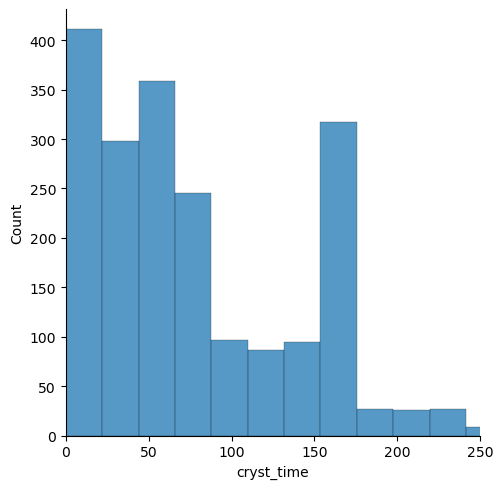

In [28]:
plt.figure()
sns.displot(df[df['Code1'] == 'MFI']['cryst_time'])
plt.xlim(0,250)

In [23]:
df[(df['Code1'] == 'MWW') & (df['osda1 smiles'] == 'C1CCCNCC1')]

,Si,Al,P,Na,K,Li,Sr,Rb,Cs,Ba,...,OH/T,OH/T_qt,F/T,F/T_qt,H2O/T,H2O/T_qt,sda1/T,sda1/T_qt,cryst_temp_qt,cryst_time_qt
957,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3244,0.021418,0.000358,0.0,0.003855,0.0,0.0,0.0,0.0,0.0,0.0,...,0.141635,0.593594,0.0,0.0,44.260844,0.863854,0.344251,0.620620,0.301802,0.736737
3879,0.047191,0.000788,0.0,0.008494,0.0,0.0,0.0,0.0,0.0,0.0,...,0.141635,0.593594,0.0,0.0,19.179699,0.532533,0.344251,0.620620,0.301802,0.639139
3880,0.047191,0.000788,0.0,0.008494,0.0,0.0,0.0,0.0,0.0,0.0,...,0.141635,0.593594,0.0,0.0,19.179699,0.532533,0.344251,0.620620,0.301802,0.639139
3881,0.047191,0.000788,0.0,0.008494,0.0,0.0,0.0,0.0,0.0,0.0,...,0.141635,0.593594,0.0,0.0,19.179699,0.532533,0.344251,0.620620,0.301802,0.639139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28026,0.021277,0.000000,0.0,0.004255,0.0,0.0,0.0,0.0,0.0,0.0,...,0.181818,0.627294,0.0,0.0,40.909091,0.824855,0.454545,0.696697,0.301802,0.848849
28027,0.021277,0.000000,0.0,0.004255,0.0,0.0,0.0,0.0,0.0,0.0,...,0.181818,0.627294,0.0,0.0,40.909091,0.824855,0.454545,0.696697,0.301802,0.848849
28030,0.021277,0.002128,0.0,0.004255,0.0,0.0,0.0,0.0,0.0,0.0,...,0.181818,0.627294,0.0,0.0,40.909091,0.824855,0.454545,0.696697,0.301802,0.848849
28699,0.023650,0.001987,0.0,0.007095,0.0,0.0,0.0,0.0,0.0,0.0,...,0.369004,0.777566,0.0,0.0,36.900369,0.755111,0.369004,0.638670,0.301802,0.764264


In [24]:
dataset.qts

{'Si/Al': QuantileTransformer(random_state=0),
 'Al/P': QuantileTransformer(random_state=0),
 'Si/Ge': QuantileTransformer(random_state=0),
 'Si/B': QuantileTransformer(random_state=0),
 'Na/T': QuantileTransformer(random_state=0),
 'K/T': QuantileTransformer(random_state=0),
 'OH/T': QuantileTransformer(random_state=0),
 'F/T': QuantileTransformer(random_state=0),
 'H2O/T': QuantileTransformer(random_state=0),
 'sda1/T': QuantileTransformer(random_state=0),
 'cryst_temp': QuantileTransformer(random_state=0),
 'cryst_time': QuantileTransformer(random_state=0)}